# Results summary


In [3]:
# utils
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from sincfold.metrics import f1_tol
from sincfold.utils import dot2bp
import json

dotbracket_format = ["IPknot", "ProbKnot", "RNAstructure", "LinearFold", "REDfold", 
                          "LinearFold-C", "LinearFold-V", "LinearPartition-C", "LinearPartition-V", "MXfold2"]

def get_f1(x):
    if x.method in dotbracket_format:
        _, _, f1 = f1_tol(x["ref"], dot2bp(x["folding"]))
    else:
        _, _, f1 = f1_tol(x["ref"], json.loads(x["folding"]))
    
    return f1

## Ablation study 

In [5]:
methods = ["C1D", "R1D", "C1D+C2D", "C1D+R2D", "R1D+R2D"]
summary = pd.read_csv(f"ablation.csv", index_col="id")

dataset = pd.read_csv(f"../data/ablation.csv", index_col="id")
splits = pd.read_csv(f"../data/ablation_splits.csv")

# add references and compute F1 per sequence
summary["ref"] = dataset.loc[summary.index]["base_pairs"].apply(lambda x: json.loads(x))        

summary["F1"] = summary.apply(get_f1, axis=1)

# add fold id
for fold_number in splits.fold_number.unique():
    test_ids = splits[(splits.partition=="test") & (splits.fold_number==fold_number)].id
    summary.loc[summary.index.isin(test_ids), "fold_number"] = fold_number

# average over folds
summary_avg = summary.groupby(["fold_number", "method"]).F1.mean().unstack().T

print("Median F1 score")
display(summary_avg.loc[methods].T.median())


Median F1 score


method
C1D        0.726330
R1D        0.742760
C1D+C2D    0.820450
C1D+R2D    0.830971
R1D+R2D    0.849450
dtype: float64

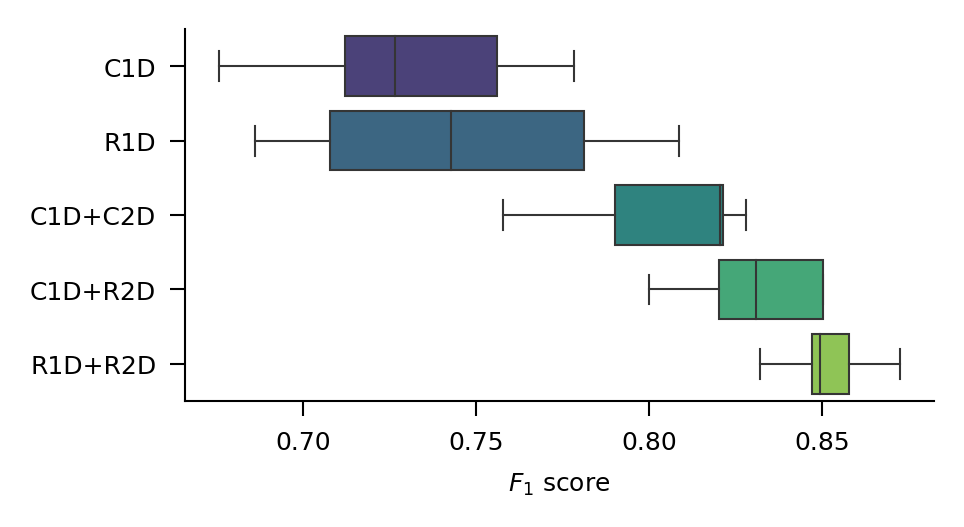

In [6]:
plt.figure(figsize=(3.22, 1.61), dpi=300)
ax = sns.boxplot(data=summary_avg.T,  orient="h", palette="viridis" , order=methods, linewidth=0.5)
ax.set_xlabel("$F_1$ score", fontsize=6)
ax.set_ylabel("")
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(width=0.5)

plt.savefig("ablation.pdf", 
               bbox_inches='tight', 
               transparent=False,
               dpi=300,
               pad_inches=0)

# Interconnection distances

In [7]:
bins = np.linspace(0, 400, 40+1)
histn = {}
for method in ["R1D", "R1D+R2D"]:
    method_summary = summary[summary.method==method]
    tps = [] # true positives

    for k in range(len(method_summary)):
        for p in method_summary.iloc[k].ref:
            tp = 1
            if p not in json.loads(method_summary.iloc[k].folding): # strict error
                tp = 0
            tps.append([p[1]-p[0], tp])
    tps = pd.DataFrame(tps, columns=["dist", "tp"])
 
    h = []
    for i in range(len(bins)-1):
        nn = tps[(tps.dist>bins[i]) & (tps.dist<=bins[i+1])].tp.count()
        tp = tps[(tps.dist>bins[i]) & (tps.dist<=bins[i+1]) &  (tps.tp==1)].tp.count()
        if nn>0: h.append(tp/nn)
        else: h.append(0)
    histn[method] = h

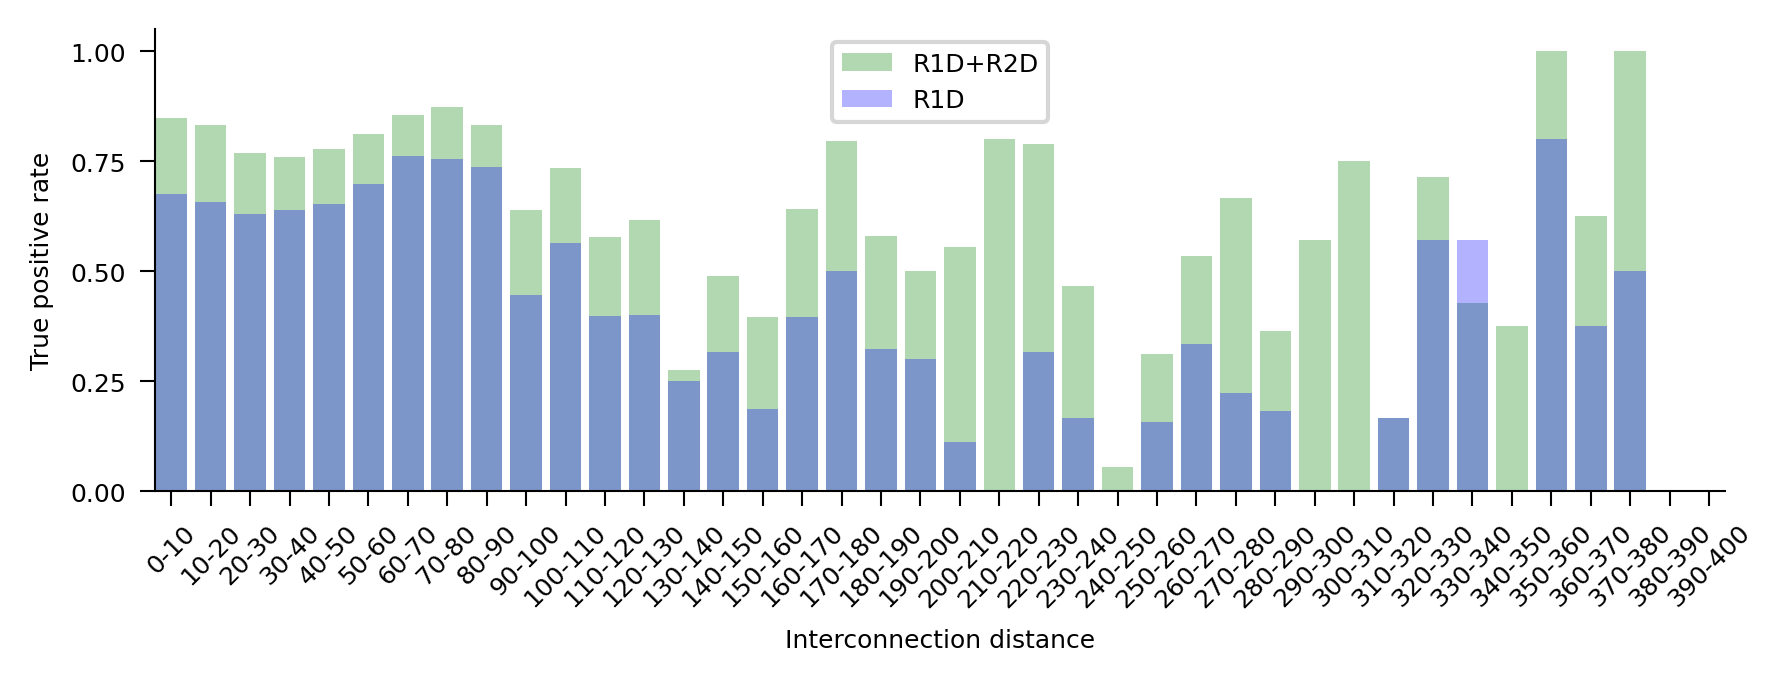

In [8]:
plt.figure(figsize=(6.75, 2), dpi=300)

strbins = []
for i in range(len(bins)-1):
    strbins.append(str(int(bins[i])) + "-" + str(int(bins[i+1])))

plt.bar(x=strbins, height=histn["R1D+R2D"], color="g", alpha=0.3, label="R1D+R2D")
plt.bar(x=strbins, height=histn["R1D"], color="b", alpha=0.3, label="R1D")
plt.xticks(rotation = 45, fontsize=6)
plt.yticks(fontsize=6)
plt.ylabel("True positive rate", fontsize=6)
plt.xlabel("Interconnection distance", fontsize=6)
plt.legend(fontsize=6)

plt.autoscale(enable=True, axis='x', tight=True)

ax = plt.gca()
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(width=0.5)

plt.savefig("distR.pdf", 
               bbox_inches='tight', 
               transparent=False,
               dpi=300,
               pad_inches=0)

# RNAstralign

In [10]:
methods = ['RNAfold', 'RNAstructure', 'ProbKnot', 'IPknot', 'LinearPartition-V', 'LinearFold-V', 
           'LinearPartition-C', 'LinearFold-C',   
           'MXfold2', 'UFold', 'REDfold', 'sincFold']

summary = pd.read_csv(f"RNAstralign.csv", index_col="id")

dataset = pd.read_csv(f"../data/RNAstralign.csv", index_col="id")
splits = pd.read_csv(f"../data/RNAstralign_splits.csv")

# add references and compute F1 per sequence
summary["ref"] = dataset.loc[summary.index]["base_pairs"].apply(lambda x: json.loads(x))        

summary["F1"] = summary.apply(get_f1, axis=1)

# add fold id
for fold_number in splits.fold_number.unique():
    test_ids = splits[(splits.partition=="test") & (splits.fold_number==fold_number)].id
    summary.loc[summary.index.isin(test_ids), "fold_number"] = fold_number

# add average over folds
summary = summary.groupby(["fold_number", "method"]).F1.mean().unstack().T

for method in methods:
    if method not in summary.index:
        summary = pd.concat((summary, pd.Series(index=[method])))

print("Median F1 score")
display(summary.loc[methods].T.mean())

Median F1 score


method
RNAfold              0.654902
RNAstructure         0.662629
ProbKnot             0.660613
IPknot               0.712555
LinearPartition-V    0.652507
LinearFold-V         0.654941
LinearPartition-C    0.730836
LinearFold-C         0.731955
MXfold2              0.742338
UFold                0.971260
REDfold              0.979693
sincFold             0.984636
dtype: float64

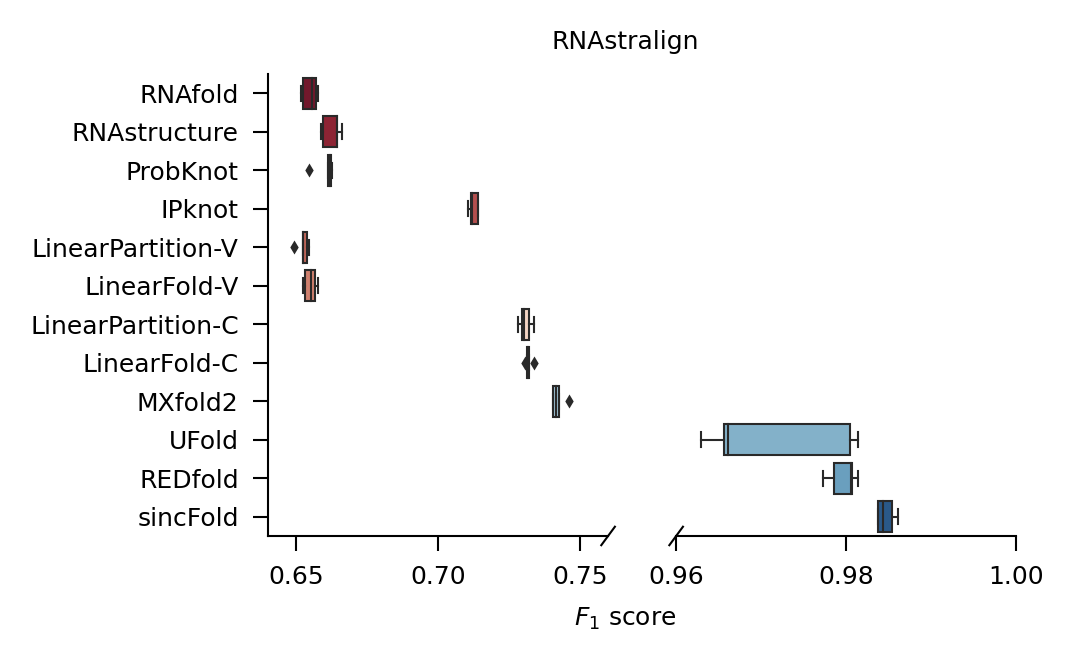

In [11]:
base = sns.color_palette("RdBu", 25)
palette = base[:6] + base[9:11] + base[17:20] + base[-2:-1]

fig, ax = plt.subplots(1, 2, figsize=(3.22, 2), dpi=300)
sns.boxplot(data=summary.T,  orient="h", palette=palette, order=methods, ax=ax[0], linewidth=0.5, fliersize=1)
sns.boxplot(data=summary.T,  orient="h", palette=palette, order=methods, ax=ax[1], linewidth=0.5, fliersize=1)
ax[0].set_xlim(.64, .76)
ax[1].set_xlim(.96, 1)
ax[1].set_ylabel("")
# remove ticks from ax[1]
ax[1].set_yticks([])
ax[0].set_title("RNAstralign", x=1.05, fontsize=6)

ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[0].tick_params(labelright=False)  

for axi in ax:
    axi.spines['left'].set_linewidth(0.5)
    axi.spines['bottom'].set_linewidth(0.5)
    axi.tick_params(labelsize=6)
    axi.tick_params(width=0.5)

d = .020 
kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
ax[0].plot((1 - d, 1 + d), (-d, +d), lw=0.5, **kwargs)  

kwargs.update(transform=ax[1].transAxes)  
ax[1].plot((0 - d, 0 + d), (-d, +d), lw=0.5, **kwargs)  

ax[0].set_xlabel("$F_1$ score", x=1.05, fontsize=6)
ax[0].set_ylabel("")

plt.savefig("RNAstralign.pdf", 
               bbox_inches='tight', 
               transparent=False,
               dpi=300,
               pad_inches=0)

# ArchiveII

In [49]:
dotbracket_format = ["IPknot",  "RNAstructure", "REDfold", 
                          "LinearFold-C", "LinearFold-V", "LinearPartition-C", "LinearPartition-V", "MXfold2"]

methods = ['RNAfold', 'RNAstructure', 'ProbKnot', 'IPknot', 'LinearPartition-V', 'LinearFold-V', 
           'LinearPartition-C', 'LinearFold-C',   
           'MXfold2', 'UFold', 'REDfold', 'sincFold']

summary = pd.read_csv(f"ArchiveII.csv", index_col="id")

dataset = pd.read_csv(f"../data/ArchiveII.csv", index_col="id")
splits = pd.read_csv(f"../data/ArchiveII_splits.csv")

# add references and compute F1 per sequence
summary["ref"] = dataset.loc[summary.index]["base_pairs"].apply(lambda x: json.loads(x))        

summary["F1"] = summary.apply(get_f1, axis=1)

# add fold id
for fold_number in splits.fold_number.unique():
    test_ids = splits[(splits.partition=="test") & (splits.fold_number==fold_number)].id
    summary.loc[summary.index.isin(test_ids), "fold_number"] = fold_number

# add average over folds
summary_avg = summary.groupby(["fold_number", "method"]).F1.mean().unstack().T

print("Median F1 score")
display(summary_avg.loc[methods].T.median())

Median F1 score


method
RNAfold              0.611853
RNAstructure         0.593509
ProbKnot             0.605120
IPknot               0.642508
LinearPartition-V    0.619238
LinearFold-V         0.639243
LinearPartition-C    0.646008
LinearFold-C         0.639243
MXfold2              0.633085
UFold                0.876537
REDfold              0.848026
sincFold             0.911027
dtype: float64

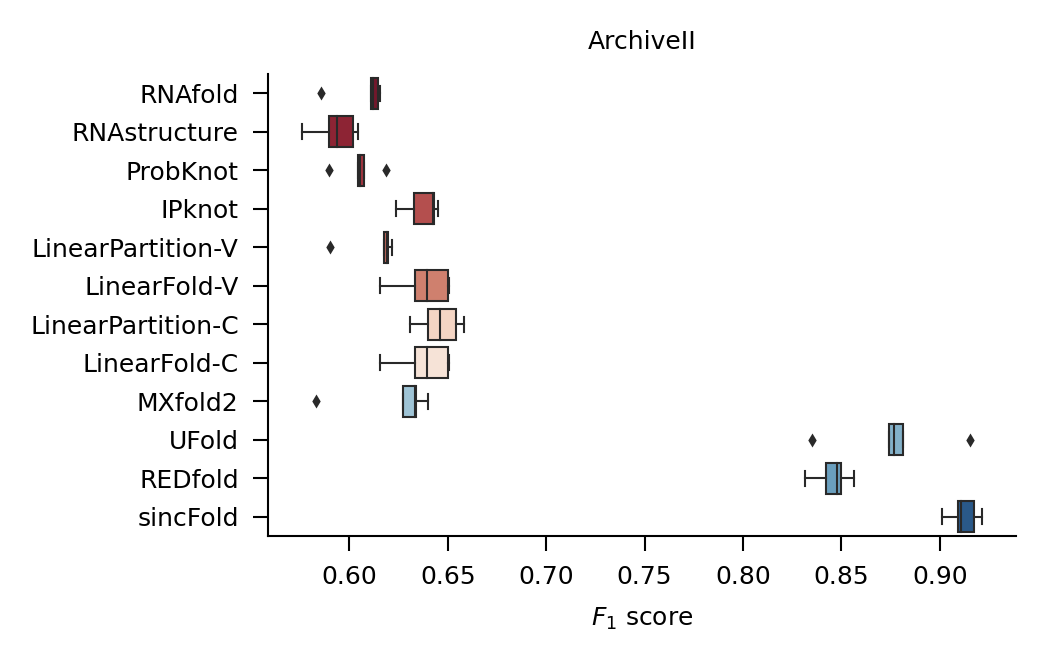

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(3.22, 2), dpi=300)
ax = sns.boxplot(data=summary_avg.T,  orient="h", palette=palette, order=methods, linewidth=0.5, fliersize=1)
ax.set_xlabel("$F_1$ score", fontsize=6)
ax.set_ylabel("")
ax.set_title("ArchiveII", fontsize=6)

#ax.set(yticklabels=[])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(labelright=False)  

ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.tick_params(labelsize=6)
ax.tick_params(width=0.5)

plt.savefig("ArchiveII.pdf", 
               bbox_inches='tight', 
               transparent=False,
               dpi=300,
               pad_inches=0)

### Performance per family

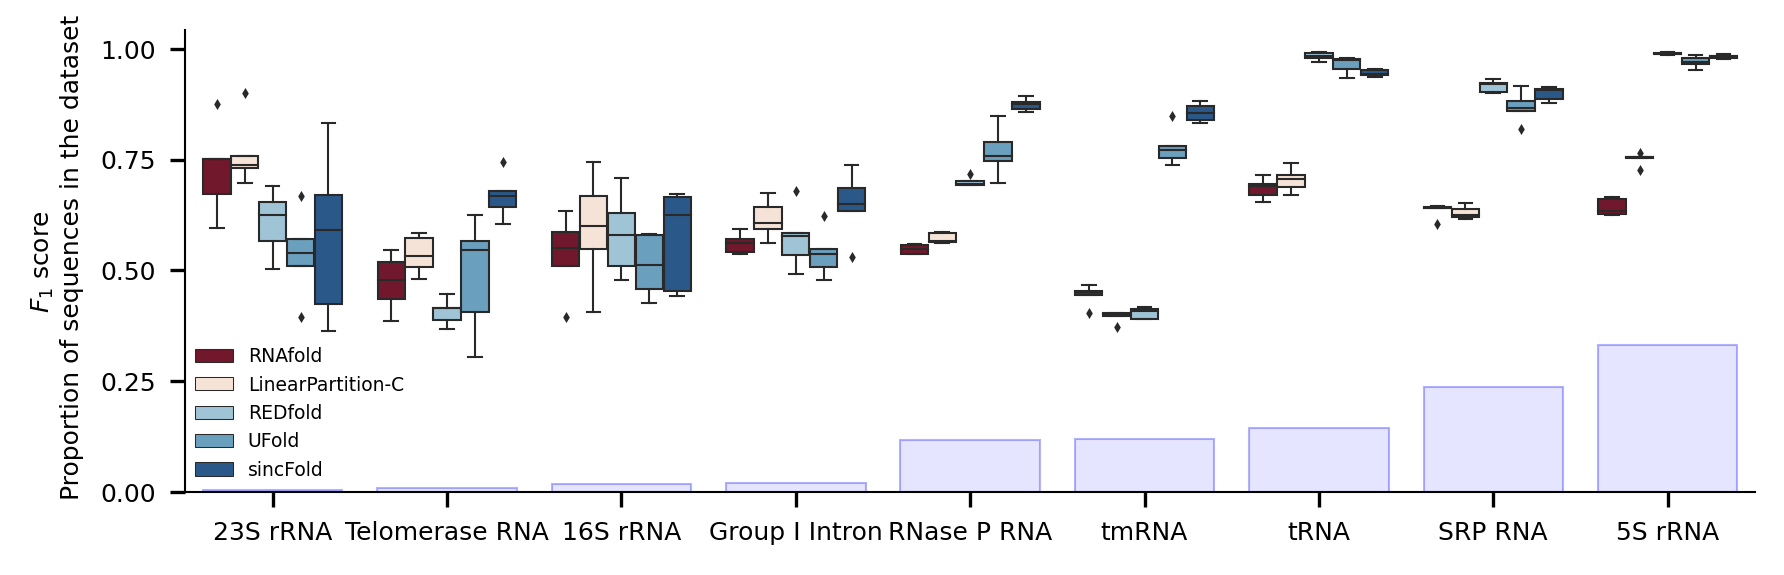

In [77]:
# Select best perfomring methods for the plot 
methods = ['RNAfold', 'LinearPartition-C', 'REDfold', 'UFold', 'sincFold']
summary = summary[summary.method.isin(methods)]

summary["Family"] = summary.index.str.split("_").str[0]

# Add complete family names
summary["Family"] = summary["Family"].replace({"5s": "5S rRNA", "srp": "SRP RNA", "RNaseP": "RNase P RNA", 
                                               "grp1": "Group I Intron", "16s": "16S rRNA", "23s": "23S rRNA",
                                               "telomerase": "Telomerase RNA"})

fam_count = summary.groupby("Family").ref.count()
fam_count /= fam_count.sum()
fam_count.sort_values(ascending=True, inplace=True)

# get average per fold per method and family
summary_avg = summary.groupby(["fold_number", "method", "Family"]).F1.mean().reset_index()

pal = palette[:1] + palette[7:8] + palette[8:9] + palette[10:11] + palette[-1:]

plt.figure(figsize=(6.75, 2), dpi=300)
bp = sns.barplot(x=fam_count.index, y=fam_count,
                 facecolor=(0.0,0.0,1.0,0.1), linewidth=.5, 
                 edgecolor=(0.0,0.0,1.0,0.3), zorder=-1)

vp = sns.boxplot(data=summary_avg,  x="Family", y="F1", hue="method", linewidth=0.5, fliersize=.5,
                 zorder=1, hue_order=methods, order=fam_count.index, palette=pal)
vp.set_ylabel("$F_1$ score \n Proportion of sequences in the dataset", fontsize=6)
vp.legend(bbox_to_anchor=(.15,.35), ncol=1, fontsize=4.5, frameon=False)

vp.spines[['right', 'top']].set_visible(False)
vp.spines['left'].set_linewidth(0.5)
vp.spines['bottom'].set_linewidth(0.5)

plt.xlabel("")
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.savefig("families.pdf", 
               bbox_inches='tight', 
               transparent=False,
               dpi=300,
               pad_inches=0)

### Performance by train-test similarity

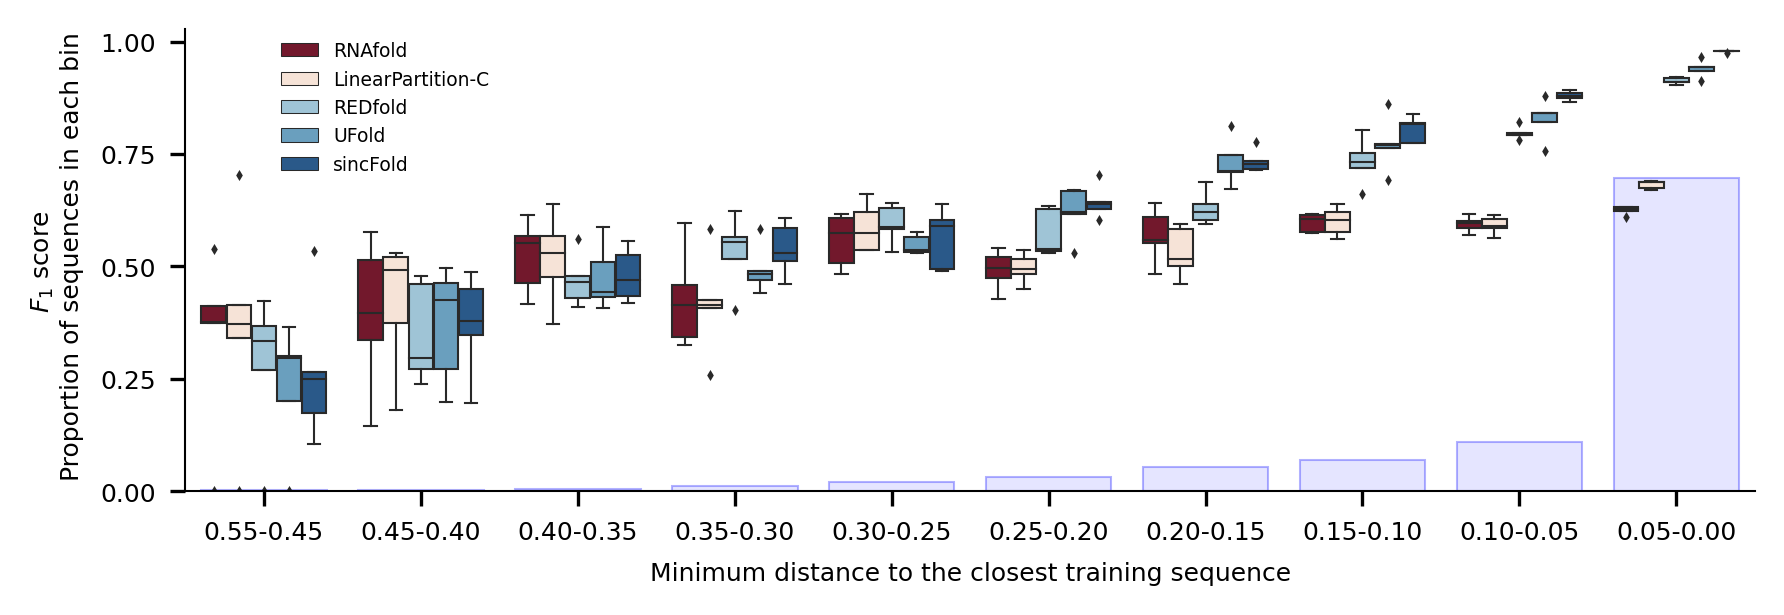

In [68]:
dist = splits[splits.partition=="test"].set_index("id")

summary["min_train_dist"] = dist.loc[summary.index, "min_train_dist"]
summary["dist_bin"] = pd.cut(summary["min_train_dist"], include_lowest=True,  bins=[0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.55])
summary['dist_bin'] = summary.dist_bin.apply(lambda x: f'{x.right:.2f}-{x.left:.2f}' if x.right != 0.05 else f'{x.right:.2f}-{0:.2f}')

dist_count = summary.groupby("dist_bin").ref.count()
dist_count /= dist_count.sum()
#dist_count.sort_values(ascending=True, inplace=True)

# get average per fold per method and dist
summary_avg = summary.groupby(["fold_number", "method", "dist_bin"]).F1.mean().reset_index()

plt.figure(figsize=(6.75, 2), dpi=300)
bins = ['0.55-0.45', '0.45-0.40', '0.40-0.35', '0.35-0.30', '0.30-0.25', '0.25-0.20', '0.20-0.15', '0.15-0.10', '0.10-0.05', '0.05-0.00']
bp = sns.barplot(x=dist_count.index.to_numpy(), y=dist_count.values, 
                 facecolor=(0.0,0.0,1.0,0.1), linewidth=.5, 
                 edgecolor=(0.0,0.0,1.0,0.3), zorder=-1, order=bins)
vp = sns.boxplot(data=summary_avg, x="dist_bin", y="F1", hue="method", linewidth=.5, fliersize=0.5,
                 zorder=1, hue_order=methods, order=bins, palette=pal)
vp.set_ylabel("$F_1$ score \n Proportion of sequences in each bin", fontsize=6);
vp.legend(bbox_to_anchor=(0.05,.65), ncol=1, fontsize=4.5, frameon=False)
plt.xlabel("Minimum distance to the closest training sequence", fontsize=6);
vp.spines[['right', 'top']].set_visible(False);
vp.spines['left'].set_linewidth(0.5)
vp.spines['bottom'].set_linewidth(0.5)

plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.savefig("traintest_dist.pdf", 
               bbox_inches='tight', 
               transparent=False,
               dpi=300,
               pad_inches=0)

### Performance per length

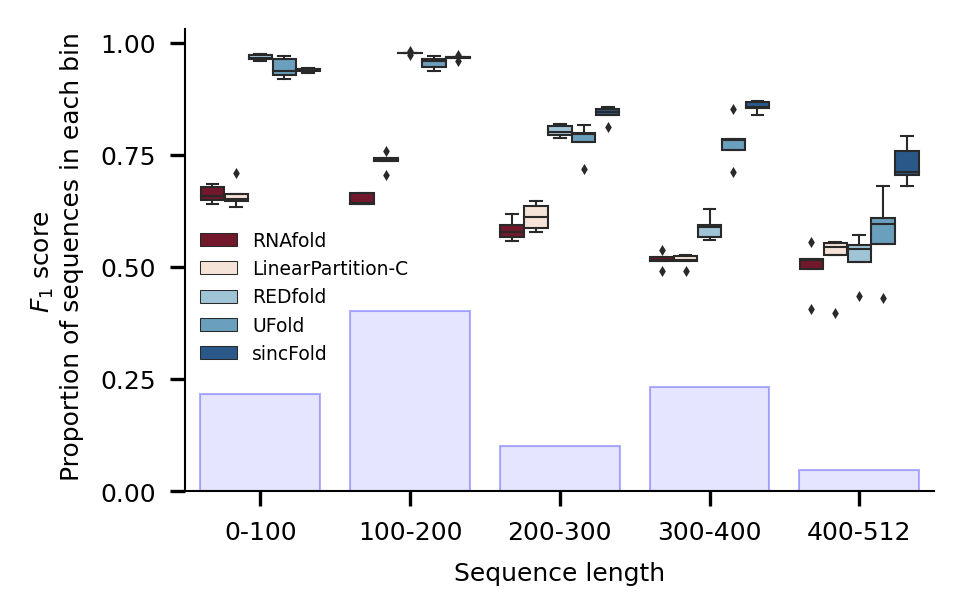

In [76]:
summary["Length"] = dataset.loc[summary.index, "len"]
summary["len_bin"] = pd.cut(summary["Length"], include_lowest=True,  bins=[0, 100, 200, 300, 400, 512])
summary['len_bin'] = summary.len_bin.apply(lambda x: f'{int(x.left)}-{int(x.right)}')

bin_count = summary.groupby("len_bin").ref.count()
bin_count /= bin_count.sum()

summary_avg = summary.groupby(["fold_number", "method", "len_bin"]).F1.mean().reset_index()

plt.figure(figsize=(3.22, 2), dpi=300)
bp = sns.barplot(x=bin_count.index, y=bin_count, 
                 facecolor=(0.0,0.0,1.0,0.1), linewidth=.5, 
                 edgecolor=(0.0,0.0,1.0,0.3), zorder=-1)
vp = sns.boxplot(data=summary_avg, x="len_bin", y="F1", hue="method", linewidth=.5, fliersize=.5, 
                 palette=pal, zorder=1, hue_order=methods, order=bin_count.index)
vp.set_ylabel("$F_1$ score \n Proportion of sequences in each bin", fontsize=6);
#vp.legend(bbox_to_anchor=(.95,.85), frameon=False, fontsize=4.5, ncol=1);
vp.legend(bbox_to_anchor=(.32,.24), frameon=False, fontsize=4.5, ncol=1);
plt.xlabel("Sequence length", fontsize=6);
vp.spines[['right', 'top']].set_visible(False);
vp.spines['left'].set_linewidth(0.5)
vp.spines['bottom'].set_linewidth(0.5)

plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.savefig("lengths.pdf", 
               bbox_inches='tight', 
               transparent=False,
               dpi=300,
               pad_inches=0)